# 1. Setup
## 1.1 Import Modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/"CV 1D Project"/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: data/test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: data/test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: data/test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: data/test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: data/test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: data/test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: data/test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: data/test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: data/test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: data/test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: data/test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: data/test-jpg-additional/test-jpg-additional/file_5

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import pandas as pd
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
import numpy as np
# also kaleido for "go" plot to be saved
# get this specific version pip install kaleido==0.1.0post1
!pip install kaleido

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 28.6 MB/s eta 0:00:00


## 1.2 Set Image Transform based on Model

In [4]:
# ResNet & DenseNet
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# EfficientNet_b1
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(240),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# RegNet
# transform = transforms.Compose([
#     transforms.Resize(232),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# ConvNext
# transform = transforms.Compose([
#     transforms.Resize(236),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

## 1.3 Prepare Dataframe and Tags

### Remember to adjust the file path as needed

In [5]:
# ADJUST FILE PATH ACCORDINGLY
df = pd.read_csv("/content/data/planet/planet/train_classes.csv")
# df # (Uncomment to preview)

# Prepare tags dictionary

all_tags = set()
for tags in df['tags'].str.split():
    all_tags.update(tags)
tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_tags))}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
print(tag_to_idx)
print(len(tag_to_idx))
all_tags = list(sorted(all_tags))
print(all_tags)


{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}
17
['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


## 1.4 Prepare train test split

### 1.4.1 Prepare data augmentation

In [6]:
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(),
])

### 1.4.2 Define Dataset Class (Use direct df instead of csv)
### Indicate if data augmentation is to be used here

In [59]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        # if type(csv_file) != str:
        #     self.df = csv_file
        # else:
        #     self.df = pd.read_csv(csv_file)
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        if "aug" in img_name:
            img_path = os.path.join("data/augmented_images/", f"{img_name}.jpg")
            #img_path = os.path.join(self.img_dir, f"{img_name}")
        else:
            img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        #print(image.shape)
        # Data Augmentation
        image_np = image.permute(1, 2, 0).cpu().numpy()
        # Ensure the image is in the range [0, 255] and has dtype uint8 if needed
        #image_np = (image_np * 255).astype(np.uint8)
        augmented = augmentation_pipeline(image=image_np)
        augmented_image = augmented['image']
        image = augmented_image

        tags = self.df.iloc[idx, 1].split()
        labels = torch.zeros(len(tag_to_idx))
        for tag in tags:
            labels[tag_to_idx[tag]] = 1

        return image, labels

### 1.4.2.1 (Optional) Import Resampled Dataframes

In [27]:
# LP_undersampled_df = pd.read_csv("LP_undersampled_df.csv")
# #LP_oversampled_df = pd.read_csv("LP_oversampled_df.csv") # Not in github due to large size, download from google drive
# ML_undersampled_df = pd.read_csv("ML_undersampled_df.csv")
# ML_oversampled_duplicate_df = pd.read_csv("ML_oversampled_duplicate_df.csv")
# ML_oversampled_augment_df = pd.read_csv("ML_oversampled_augment_df.csv") # Must download zip file from google drive, and put into same directory as data
# REMEDIAL_modified_df = pd.read_csv("REMEDIAL_modified_df.csv")

### 1.4.3 Perform splitting and prepare dataloaders

#### For now, use random state 42 for reproducibility

#### Remember to adjust file path as needed

#### Select resampled dataframe if using those and do not split again if so

In [60]:
df_to_load = df

dataset = MultiLabelImageDataset(df_to_load, img_dir="/content/data/planet/planet/train-jpg", transform=transform)
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)


### 1.4.4 Ensure rare classes are in train and validation

In [ ]:
# TBC

## 1.5 Prepare DataLoader

In [61]:
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## 1.6 Prepare CPU or CUDA Device

In [62]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## 1.7 Prepare Classifier classes

### Note: All layers are unfrozen
### With an added FC layer to the number of classes

In [63]:
import torchvision.models as models
from torch import nn

num_classes = 17

def ResNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.resnet50(weights='DEFAULT')
    num_ftrs = model_ft.fc.in_features

    # freeze all the parameters in the network except the final layer
    for param in model_ft.parameters():
        param.requires_grad = False

    # replace the last fully connected layer
    #model_ft.fc = nn.Linear(num_ftrs, num_classes)
    model_ft.fc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(2048, 128), # 512 for resnet18 or 2048 for resnet 50
      nn.ReLU(inplace=True),
      nn.Dropout(.2),
      nn.Linear(128, num_classes),
      #nn.Sigmoid()
    )
    return model_ft

def DenseNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.densenet121(weights='DEFAULT')
    num_ftrs = model_ft.classifier.in_features

    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False

    # replace the last fully connected layer
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    return model_ft

def EfficientNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.efficientnet_b1(weights='DEFAULT')
    # num_ftrs = model_ft.classifier.in_features

    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False

    # replace the last fully connected layer
    model_ft.classifier = nn.Linear(1280, num_classes)
    return model_ft

def RegNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.regnet_y_8gf(weights='DEFAULT')
    print(model_ft)
    num_ftrs = model_ft.fc.in_features

    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False

    # replace the last fully connected layer
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

def ConvNextClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.convnext_tiny(weights='DEFAULT')
    num_ftrs = model_ft.classifier[2].in_features

    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False

    # replace the last fully connected layer
    model_ft.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(num_ftrs, num_classes)
        )
    return model_ft

# 2. Training

## 2.1 Prepare Model

### 2.1.1 Initialise Model

In [85]:
model = ResNetClassifier(num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 2.1.2 (Optional) Load Model Weights

In [90]:
def unfreeze_layers_by_layer(model, num_layers_to_unfreeze):
    """
    Unfreeze a specified number of layers in the model, starting from the last layer (e.g., fc)
    and working backward, ensuring the last layer is always unfrozen.

    Parameters:
        model: The model object (e.g., ResNet)
        num_layers_to_unfreeze: The number of layers (modules) to unfreeze, including the last layer.
    """
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Get the layers in reverse order
    layers = list(model.named_children())[::-1]  # Reverse the layers to start from the last layer

    # Always unfreeze the last layer (e.g., 'fc')
    unfrozen_layers = set()  # Keep track of unfrozen layers
    for name, module in layers:
        if name == 'fc':  # Replace 'fc' with your last layer's name if different
            for param in module.parameters():
                param.requires_grad = True
            unfrozen_layers.add(name)
            break

    # Unfreeze the specified number of layers starting from the second-to-last layer
    count = 1  # Already unfrozen 'fc'
    for name, module in layers:
        if count >= num_layers_to_unfreeze:
            break
        if name not in unfrozen_layers:  # Skip already unfrozen layers (e.g., 'fc')
            for param in module.parameters():
                param.requires_grad = True
            unfrozen_layers.add(name)
            count += 1



## 2.2 Define train and validation loops

In [91]:
def train_loop(dataloader, val_dataloader, model, loss_fn, threshold, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, train_score = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        #loss = loss.mean()  # If doing focal loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred_tags = torch.sigmoid(pred).detach().cpu().numpy() > threshold
        true_tags = y.cpu().numpy()
        train_loss += loss.item()
        train_score += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

        if batch % 64 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        #if batch % 640 == 0:
        #    val_loop(val_dataloader, model, loss_fn, threshold)

    train_loss /= num_batches
    train_score /= num_batches
    return train_loss, train_score


def val_loop(dataloader, model, loss_fn, threshold):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, val_score = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item() # Do .mean() if doing focal loss

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > threshold #0.24
            true_tags = y.cpu().numpy()
            val_score += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    val_loss /= num_batches
    val_score /= num_batches

    print(f"Val Error: \n f2 score: {val_score:.5f}, avg loss: {val_loss:>8f} \n")
    return val_loss, val_score

## 2.3 Define loss functions

In [92]:
def hamming_loss(pred, target):
    """
    Computes the Hamming loss for multi-label classification.

    Args:
        pred: Predicted probabilities (after sigmoid), shape (batch_size, num_labels).
        target: Ground truth labels, shape (batch_size, num_labels).

    Returns:
        Hamming loss (scalar).
    """
    return torch.mean(torch.abs(pred - target))


def compute_class_weights(targets):
    total_samples = targets.size(0)
    positive_counts = targets.sum(dim=0)  # Number of positive samples per class
    negative_counts = total_samples - positive_counts  # Number of negative samples per class

    positive_weights = total_samples / (positive_counts + 1e-5)  # Avoid division by zero
    negative_weights = total_samples / (negative_counts + 1e-5)

    return positive_weights, negative_weights

def weighted_bce_loss(predictions, targets, positive_weights, negative_weights):
    # Clamp predictions to avoid log(0) issues
    predictions = torch.clamp(predictions, min=1e-5, max=1 - 1e-5)

    # Compute weighted binary cross-entropy
    bce_loss = - (
        positive_weights * targets * torch.log(predictions) +
        negative_weights * (1 - targets) * torch.log(1 - predictions)
    )
    #print(bce_loss.mean())
    # Take mean over batch and classes
    return bce_loss.mean()

def weighted_BCE(pred, target):
    positive_weights, negative_weights = compute_class_weights(target)
    return weighted_bce_loss(pred, target, positive_weights, negative_weights)

## 2.4 Define training parameters

In [95]:
from torch.optim.lr_scheduler import StepLR
learning_rate = 1e-3
epochs = 10
threshold = 0.24
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

In [73]:
# MANUAL UNFREEZE
for param in model.parameters():
    param.requires_grad = True

## 2.5 Train Model

In [96]:
train_loss = []
train_score = []
val_loss = []
val_score = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_train_loss, epoch_train_score = train_loop(train_dataloader, val_dataloader, model, loss_fn, threshold, optimizer)
    epoch_val_loss, epoch_val_score = val_loop(val_dataloader, model, loss_fn, threshold)
    train_loss.append(epoch_train_loss)
    train_score.append(epoch_train_score)
    val_loss.append(epoch_val_loss)
    val_score.append(epoch_val_score)
    if t > 0:
      # means t at 1, means 2nd epoch just finished
      unfreeze_layers_by_layer(model, (t+1)//2) # on 3rd epoch onwards, have last 2 layers unfrozen
      lr_scheduler.step()
print("Done!")

Epoch 1
-------------------------------
loss: 0.699689  [  128/36431]
loss: 0.179241  [ 8320/36431]
loss: 0.127584  [16512/36431]
loss: 0.167233  [24704/36431]
loss: 0.142703  [32896/36431]
Val Error: 
 f2 score: 0.86740, avg loss: 0.131674 

Epoch 2
-------------------------------
loss: 0.155029  [  128/36431]
loss: 0.148564  [ 8320/36431]
loss: 0.123712  [16512/36431]
loss: 0.125114  [24704/36431]
loss: 0.105395  [32896/36431]
Val Error: 
 f2 score: 0.87419, avg loss: 0.121598 

Epoch 3
-------------------------------
loss: 0.152672  [  128/36431]
loss: 0.112683  [ 8320/36431]
loss: 0.139507  [16512/36431]
loss: 0.127389  [24704/36431]
loss: 0.115080  [32896/36431]
Val Error: 
 f2 score: 0.87728, avg loss: 0.117578 

Epoch 4
-------------------------------
loss: 0.117723  [  128/36431]
loss: 0.110026  [ 8320/36431]
loss: 0.124199  [16512/36431]
loss: 0.103194  [24704/36431]
loss: 0.128030  [32896/36431]
Val Error: 
 f2 score: 0.88153, avg loss: 0.114296 

Epoch 5
--------------------

# 3. Results

## 3.1 Plot train loss, train score, val loss, val score

In [97]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(train_loss))),
        y=train_loss,
        name="train_loss",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(val_loss))),
        y=val_loss,
        name="val_loss",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(train_score))),
        y=train_score,
        name="train_score",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(val_score))),
        y=val_score,
        name="val_score",
    ),
    row=1, col=2
)
fig.show()

## 3.2 Plot mean output of model per class per positive/negative ground truth

### 3.2.1 Define validation loop

In [98]:
def test_loop_y_test(dataloader, model, loss_fn, threshold):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, f2 = 0, 0
    y_test = np.empty((0, 17))
    y_pred_test = np.empty((0, 17))

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            y_test = np.concatenate((y_test, y.cpu().numpy()), axis=0)
            y_pred_test = np.concatenate((y_pred_test, torch.sigmoid(pred).cpu().numpy()), axis=0)

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > threshold
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    test_loss /= num_batches
    f2 /= num_batches

    print(y_test)

    print(y_test.shape)
    print(y_pred_test.shape)

    pos_probas, neg_probas = [], []
    for i in range(17):
        pos_probas.append(y_pred_test[np.where(y_test[:, i] != 0), i].mean())
        neg_probas.append(y_pred_test[np.where(y_test[:, i] == 0), i].mean())

    print(f"Test Error: \n f2 score: {f2:.5f}, avg loss: {test_loss:>8f} \n")
    return f2, test_loss, y_test, y_pred_test, pos_probas, neg_probas

### 3.2.2 Display plot

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
(4048, 17)
(4048, 17)
Test Error: 
 f2 score: 0.90723, avg loss: 0.089479 



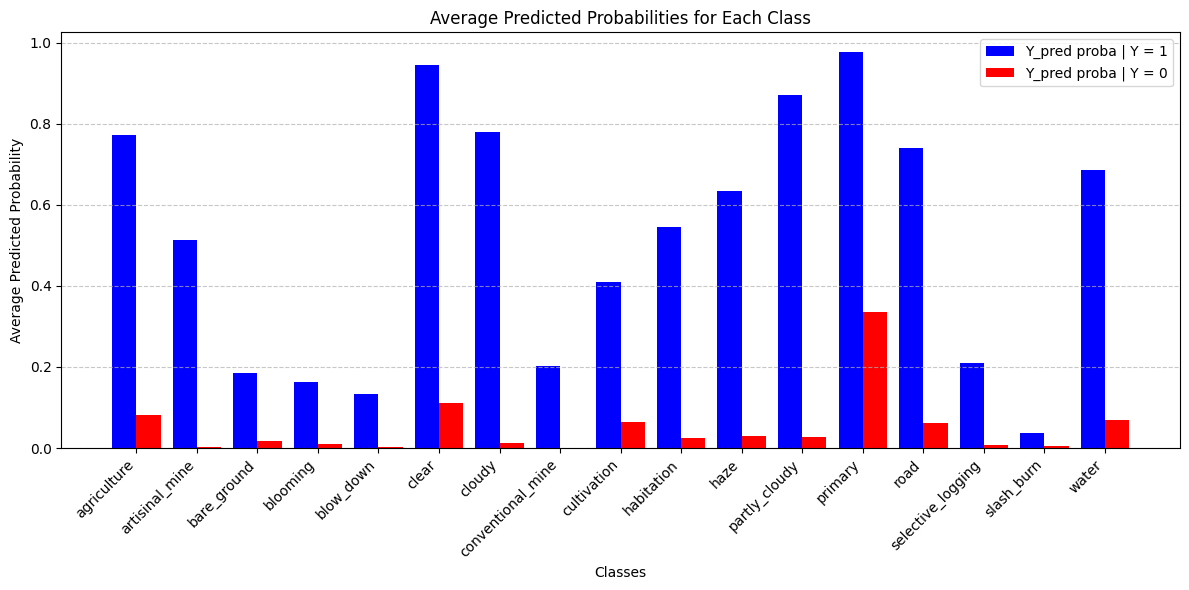

In [99]:
# This is to grade the best score per class with that best threshold
f2_loop_test, test_loss_loop_test, y_test_loop_test, y_pred_test_loop_test, pos_probas, neg_probas = test_loop_y_test(val_dataloader, model, loss_fn, threshold)

#class_labels = [f"Class {i+1}" for i in range(17)]
class_labels = all_tags

# Bar width and x-axis positions
bar_width = 0.4
x = np.arange(len(class_labels))  # Positions for the bars

# Create the grouped bar chart
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, pos_probas, width=bar_width, label="Y_pred proba | Y = 1", color='b')
plt.bar(x + bar_width/2, neg_probas, width=bar_width, label="Y_pred proba | Y = 0", color='r')

# Add labels, title, and legend
plt.xticks(x, class_labels, rotation=45, ha='right')  # Rotate class names for better readability
plt.xlabel("Classes")
plt.ylabel("Average Predicted Probability")
plt.title("Average Predicted Probabilities for Each Class")
plt.legend()

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent overlap
class_plot = plt.gcf()
plt.show()



# 3.3 Threshold Search

### 3.3.1 Define functions

In [100]:
def fbeta_score_by_class(pred_tags, true_tags, beta, average):
    """
    Calculate the F2 score for each class.
    pred_tags: numpy array of shape (batch_size, num_classes)
    true_tags: numpy array of shape (batch_size, num_classes)

    Returns:
    f2_list: numpy array of shape (num_classes,)
    """
    pred_tags = pred_tags.T
    true_tags = true_tags.T

    f2_list = np.zeros(pred_tags.shape[0])

    for i in range(pred_tags.shape[0]):
        pred_class = pred_tags[i]  # shape (batch_size,)
        true_class = true_tags[i]  # shape (batch_size,)
        f2_list[i] = fbeta_score(true_class, pred_class, beta=beta, average=average)

    return f2_list

def test_threshold_indiv_class(dataloader, model, threshold_list, num_classes):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  f2_list = np.zeros((len(threshold_list),num_classes))
  best_threshold_per_class = np.zeros(num_classes)

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      true_tags = y.cpu().numpy()

      pred = torch.sigmoid(pred).cpu().numpy()
      #print(pred.shape)

      for i in range(len(threshold_list)):
        pred_tags = pred > threshold_list[i]
        #print(pred_tags.shape)
        f2_list[i] += fbeta_score_by_class(pred_tags, true_tags, beta=2, average="micro")

  f2_list /= num_batches

  f2_list = f2_list.T   # f2_list: shape of (num_classes x len(threshold_list))

  best_score = 0
  for i in range(f2_list.shape[0]):
    idx = np.argmax(f2_list[i])
    print(f"Best threshold for class {i}: {threshold_list[idx]}, f2: {f2_list[i][idx]}")
    print("----------------------------------------------")
    best_threshold_per_class[i] = threshold_list[idx]
    best_score += f2_list[i][idx]
  best_score /= num_classes
  print(best_score)
  print(f2_list)

  return f2_list, best_threshold_per_class

### 3.3.2 Run threshold search

In [101]:
threshold_list = [i/100 for i in range(1, 61)]
num_classes = 17
f2_list, best_threshold_per_class = test_threshold_indiv_class(val_dataloader, model, threshold_list, num_classes)
threshold_to_test = best_threshold_per_class.tolist()

Best threshold for class 0: 0.46, f2: 0.913037109375
----------------------------------------------
Best threshold for class 1: 0.16, f2: 0.9951171875
----------------------------------------------
Best threshold for class 2: 0.56, f2: 0.979345703125
----------------------------------------------
Best threshold for class 3: 0.43, f2: 0.9931640625
----------------------------------------------
Best threshold for class 4: 0.53, f2: 0.995361328125
----------------------------------------------
Best threshold for class 5: 0.52, f2: 0.952294921875
----------------------------------------------
Best threshold for class 6: 0.6, f2: 0.9859375
----------------------------------------------
Best threshold for class 7: 0.04, f2: 0.998046875
----------------------------------------------
Best threshold for class 8: 0.49, f2: 0.9166015625
----------------------------------------------
Best threshold for class 9: 0.31, f2: 0.957470703125
----------------------------------------------
Best threshold 

At this point, make sure the best threshold found fits the probability graph

# 4. Testing

## 4.1 Define test submission function
## Remember to adjust image path!

In [22]:
#threshold = 0.18
#threshold_list = [0.18] * 17
#threshold_list = [0.4, 0.5, 0.35, 0.25, 0.5, 0.35, 0.4,  0.5,  0.5,  0.15, 0.5,  0.45, 0.5,  0.3, 0.35, 0.5,  0.35]
#threshold_list = [0.39, 0.16, 0.27, 0.07, 0.02, 0.39, 0.31, 0.29, 0.31, 0.22, 0.38, 0.4,  0.38, 0.21, 0.08, 0.03, 0.39]
# threshold_list= [0.38, 0.074, 0.262, 0.17200000000000001, 0.030000000000000002, 0.386,\
#  0.29000000000000004, 0.15333333333333332, 0.34400000000000003,\
#  0.23600000000000004, 0.364, 0.31800000000000006, 0.38999999999999996, 0.26,\
#  0.14, 0.038, 0.34400000000000003]
#output_csv = f"{model_name}" + str(threshold) + ".csv"  # Output CSV file
#output_csv = "LP_OS_ML_OS_ResNet50_customthresholdlist.csv"  # Output CSV file
def test_submission(model, threshold, output_csv, is_threshold_list):
    results_df = pd.DataFrame(columns=["image_name", "tags"])

    # Function to preprocess the image (modify based on your model's requirements)
    def preprocess_image(image_name):
        image_path = f"{image_name}"  # Path to images (adjust as needed)
        image = Image.open(image_path).convert("RGB")

        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        return transform(image).unsqueeze(0)  # Add batch dimension

    # Iterate over numerical file names
    current_number = 0
    while True:
        try:
            # Generate the file name
            image_name = f"test_{current_number}.jpg"
            image_path = os.path.join("/content/data/planet/planet/test-jpg", image_name)  # Adjust folder path as needed

            # Check if the file exists
            if not os.path.exists(image_path):
                print(image_path)
                print(f"File {image_name} not found. Stopping loop.")
                break

            # Preprocess the image
            input_tensor = preprocess_image(image_path)

            # Get predictions
            with torch.no_grad():
                print(current_number)
                input_tensor = input_tensor.to(device)
                output = model(input_tensor)  # Get model predictions
                if is_threshold_list:
                    output = torch.sigmoid(output).cpu().numpy()
                    output = output.flatten()
                    threshold_array = np.expand_dims(threshold, axis=0)
                    threshold_array = threshold_array.flatten()
                    predicted_tags = np.where(output > threshold_array, 1, 0)
                else:
                    output = torch.sigmoid(output).squeeze().cpu().numpy()  # Apply sigmoid for probabilities
                    predicted_tags = np.where(output > threshold, 1, 0)

                predicted_labels = [idx_to_tag[idx] for idx, pred in enumerate(predicted_tags) if pred == 1]

                # Add prediction to the list
                #predictions.append({"image_name": image_name, "predicted_tags": " ".join(predicted_labels)})

                results_df.loc[current_number] = {
                    "image_name": image_name[:-4],
                    "tags": " ".join(predicted_labels),
                }

            # Increment to the next file number
            current_number += 1

        except Exception as e:
            print(f"Error processing {image_name}: {e}")
            break

    # Iterate over numerical file names
    second_df = pd.DataFrame(columns=["image_name", "tags"])
    current_number = 0
    while True:
        try:
            # Generate the file name
            image_name = f"file_{current_number}.jpg"
            image_path = os.path.join("/content/data/test-jpg-additional/test-jpg-additional", image_name)  # Adjust folder path as needed

            # Check if the file exists
            if not os.path.exists(image_path):
                print(image_path)
                print(f"File {image_name} not found. Stopping loop.")
                break

            # Preprocess the image
            input_tensor = preprocess_image(image_path)

            # Get predictions
            with torch.no_grad():
                print(current_number)
                input_tensor = input_tensor.to(device)
                output = model(input_tensor)  # Get model predictions
                if is_threshold_list:
                    output = torch.sigmoid(output).cpu().numpy()
                    output = output.flatten()
                    threshold_array = np.expand_dims(threshold, axis=0)
                    threshold_array = threshold_array.flatten()
                    predicted_tags = np.where(output > threshold_array, 1, 0)
                else:
                    output = torch.sigmoid(output).squeeze().cpu().numpy()  # Apply sigmoid for probabilities
                    predicted_tags = np.where(output > threshold, 1, 0)

                predicted_labels = [idx_to_tag[idx] for idx, pred in enumerate(predicted_tags) if pred == 1]

                # Add prediction to the list
                #predictions.append({"image_name": image_name, "predicted_tags": " ".join(predicted_labels)})

                second_df.loc[current_number] = {
                    "image_name": image_name[:-4],
                    "tags": " ".join(predicted_labels),
                }

            # Increment to the next file number
            current_number += 1

        except Exception as e:
            print(f"Error processing {image_name}: {e}")
            break

    # Save predictions to a CSV file
    results_df = pd.concat([results_df, second_df], ignore_index=True)
    results_df.to_csv(output_csv, index=False)

    print(f"Predictions saved to {output_csv}")

## 4.2 Run test submission function

In [102]:
output_csv = "Raw_DF_ResNet50_AutoAug_10epochs_custom_freezing_LR.csv"
#threshold_to_test = 0.24
test_submission(model, threshold_to_test, output_csv, type(threshold_to_test)==list)

Streaming output truncated to the last 5000 lines.
15525
15526
15527
15528
15529
15530
15531
15532
15533
15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
1

# 5. Export & Save

## Name the pth as follows
{dataframe used}_\_{Pre-trained model used}_\_AutoAug_\_{no. of epochs}__{starting LR}_\_step_size_\_{stepsize}_\_gamma_{gamma}_\_{optimizer}.pth

In [103]:
model_name = "Raw_DF_ResNet50_AutoAug_10epochs_custom_freezing_LR" #"Raw_DF_ResNet50_AutoAug_5epochs_1e-4_staticLR_ADAM"
torch.save(model.state_dict(), f"{model_name}.pth")#f"/content/drive/MyDrive/CV 1D Project/{model_name}.pth")
#fig.write_image(f"{model_name}_loss_and_score.jpg", format="jpg") # MAKE SURE YOU HAVE pip install kaleido==0.1.0post1
class_plot.savefig(f"{model_name}_class_probabilities.jpg", format="jpg", dpi=300)

# 6. Import Model for testing instead